To use this notebook you need to create yourself a kaggle.json file containing your kaggle username and your kaggle api key that you need to create in your settings. The JSON should look like this. {
  "username": "YOUR_USERNAME",
  "key": "YOUR_API_KEY"
}




In [1]:
# Place your kaggle.json in the same directory as this notebook
import os
import shutil
from pathlib import Path

kaggle_json = Path('kaggle.json')
if not kaggle_json.exists():
    print("Please place kaggle.json in the current directory if you haven't already.")
else:
    print("Found kaggle.json")

Found kaggle.json


In [2]:
import os
import shutil
from pathlib import Path

# Setup kaggle directory
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_src = Path('kaggle.json')
kaggle_json_dest = kaggle_dir / 'kaggle.json'

if kaggle_json_src.exists():
    shutil.copy(kaggle_json_src, kaggle_json_dest)
    # Set permissions (Unix only, harmless on Windows)
    try:
        os.chmod(kaggle_json_dest, 0o600)
    except Exception:
        pass
    print(f"Moved kaggle.json to {kaggle_json_dest}")
elif kaggle_json_dest.exists():
    print(f"kaggle.json already exists at {kaggle_json_dest}")
else:
    print("Warning: kaggle.json not found. Kaggle API might fail.")

Moved kaggle.json to C:\Users\tahak\.kaggle\kaggle.json


In [3]:
# Install kaggle if not installed
!pip install -q kaggle datasets pillow

# Download datasets
import os

# Check if already downloaded to avoid redownloading
if not os.path.exists('alzheimer-mri-disease-classification-dataset.zip'):
    !kaggle datasets download -d borhanitrash/alzheimer-mri-disease-classification-dataset

if not os.path.exists('brain-tumor-mri-dataset.zip'):
    !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import all necessary libaries
import zipfile
import os
import sys
from pathlib import Path
from datasets import load_dataset
from PIL import Image
import io
import shutil
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Add src to path
sys.path.append(os.path.abspath("../src"))
from augmentations import get_train_transform, get_val_transform
from models import get_model
from training import train_model

#### Now create the alzheimer dataset

In [5]:
zip_path = "alzheimer-mri-disease-classification-dataset.zip"
extract_path = "raw_alzheimer"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)

raw_root = Path("raw_alzheimer")
alz_dir = next(raw_root.iterdir())
data_dir = alz_dir / "Data"

print("Alzheimer root:", alz_dir)
print("Data dir:", data_dir)
list(data_dir.iterdir())

train_files = [str(p) for p in data_dir.glob("train*.parquet")]
test_files  = [str(p) for p in data_dir.glob("test*.parquet")]

ds = load_dataset(
    "parquet",
    data_files={"train": train_files, "test": test_files}
)

dataset_train = ds["train"]
dataset_test  = ds["test"]

Unzipped to: raw_alzheimer
Alzheimer root: raw_alzheimer\Alzheimer MRI Disease Classification Dataset
Data dir: raw_alzheimer\Alzheimer MRI Disease Classification Dataset\Data


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
base = Path("data") / "alzheimer"
(base / "yes").mkdir(parents=True, exist_ok=True)
(base / "no").mkdir(parents=True, exist_ok=True)


def get_pil_image(image_dict):
    return Image.open(io.BytesIO(image_dict["bytes"])).convert("RGB")

def label_to_folder(label: int) -> str:
    return "no" if label == 2 else "yes"

def save_split(ds, split_name: str):
    for i, example in enumerate(ds):
        img = get_pil_image(example["image"])
        label = example["label"]

        folder = label_to_folder(label)
        out_path = base / folder / f"{split_name}_{i}.png"

        img.save(out_path)

        if i % 500 == 0:
            print(f"[{split_name}] saved {i} images...")

save_split(dataset_train, "train")
save_split(dataset_test, "test")

print("Done!")

[train] saved 0 images...
[train] saved 500 images...
[train] saved 1000 images...
[train] saved 1500 images...
[train] saved 2000 images...
[train] saved 2500 images...
[train] saved 3000 images...
[train] saved 3500 images...
[train] saved 4000 images...
[train] saved 4500 images...
[train] saved 5000 images...
[test] saved 0 images...
[test] saved 500 images...
[test] saved 1000 images...
Done!


##### Now unzip the first tumor dataset and create the tumor folder

In [7]:
zip_path = Path("brain-tumor-mri-dataset.zip")
extract_path = Path("raw_tumor")

extract_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)

tumor_dir = Path("data/tumor")
(tumor_dir / "yes").mkdir(parents=True, exist_ok=True)
(tumor_dir / "no").mkdir(parents=True, exist_ok=True)

tumor_dir

Extracted to: raw_tumor


WindowsPath('data/tumor')

In [8]:
# Source folders
root = Path("raw_tumor")
train_dir = root / "Training"
test_dir = root / "Testing"

# Target folders
target = Path("data/tumor")
(target / "yes").mkdir(parents=True, exist_ok=True)
(target / "no").mkdir(parents=True, exist_ok=True)

def copy_images(src, dst):
    src, dst = Path(src), Path(dst)
    count = 0
    for img in src.rglob("*"):
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            shutil.copy(img, dst / img.name)
            count += 1
    print(f"Copied {count} → {dst}")

# Classes
tumor_classes = ["glioma", "meningioma", "pituitary"]
no_tumor_class = "notumor"

for cls in tumor_classes:
    copy_images(train_dir / cls, target / "yes")

copy_images(train_dir / no_tumor_class, target / "no")

for cls in tumor_classes:
    copy_images(test_dir / cls, target / "yes")

copy_images(test_dir / no_tumor_class, target / "no")


Copied 1321 → data\tumor\yes
Copied 1339 → data\tumor\yes
Copied 1457 → data\tumor\yes
Copied 1595 → data\tumor\no
Copied 300 → data\tumor\yes
Copied 306 → data\tumor\yes
Copied 300 → data\tumor\yes
Copied 405 → data\tumor\no


- There are 5120 Training Images for Alzheimer Detection and 1280 Test Images so in total 6400.
- There are 7023 Images in the Tumor Detection Dataset with different tumors
- The total dataset size is then 13423
- Now turn the data into a final datset which contains 3 different classes for healthy, alzheimer and tumor

In [9]:
# Source directories
alz_dir = Path("data/alzheimer")
tumor_dir = Path("data/tumor")

# Target unified dataset
final_root = Path("final_data")
(final_root / "0_healthy").mkdir(parents=True, exist_ok=True)
(final_root / "1_alzheimer").mkdir(parents=True, exist_ok=True)
(final_root / "2_tumor").mkdir(parents=True, exist_ok=True)

def copy_images(src, dst):
    src, dst = Path(src), Path(dst)
    count = 0
    for img in src.rglob("*"):
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            target_path = dst / img.name

            # Avoid filename collisions
            if target_path.exists():
                target_path = dst / (img.stem + "_dup" + img.suffix)

            shutil.copy(img, target_path)
            count += 1
    print(f"Copied {count} images → {dst}")


# 0 = HEALTHY
copy_images(alz_dir / "no", final_root / "0_healthy")
copy_images(tumor_dir / "no", final_root / "0_healthy")

# 1 = ALZHEIMER
copy_images(alz_dir / "yes", final_root / "1_alzheimer")

# 2 = TUMOR
copy_images(tumor_dir / "yes", final_root / "2_tumor")


Copied 3200 images → final_data\0_healthy
Copied 2000 images → final_data\0_healthy
Copied 3200 images → final_data\1_alzheimer
Copied 5023 images → final_data\2_tumor


##### Now generate the dataset for training, validation and testing

In [10]:
IMG_SIZE = 224
# Using transforms from src/augmentations.py
train_transform = get_train_transform(IMG_SIZE)
val_test_transform = get_val_transform(IMG_SIZE)

data_root = Path("final_data")

# Load dataset without transform first (transforms applied in split wrapper)
full_dataset = datasets.ImageFolder(root=data_root)

print("Classes:", full_dataset.classes)
print("class_to_idx:", full_dataset.class_to_idx)
print("Total images:", len(full_dataset))

Classes: ['0_healthy', '1_alzheimer', '2_tumor']
class_to_idx: {'0_healthy': 0, '1_alzheimer': 1, '2_tumor': 2}
Total images: 26846


In [11]:
total_size = len(full_dataset)
train_size = int(0.85 * total_size)
val_size   = int(0.10 * total_size)
test_size  = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms using a wrapper class to avoid sharing the underlying dataset transform
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

train_ds = ApplyTransform(train_subset, transform=train_transform)
val_ds = ApplyTransform(val_subset, transform=val_test_transform)
test_ds = ApplyTransform(test_subset, transform=val_test_transform)

len(train_ds), len(val_ds), len(test_ds)

(22819, 2684, 1343)

In [ ]:
BATCH_SIZE = 32

# Use num_workers=0 on Windows to avoid multiprocessing issues in Jupyter
import platform
import sys
# Force 0 workers on Windows and Colab to prevent crashes/OOM
NUM_WORKERS = 0 if (platform.system() == 'Windows' or 'google.colab' in sys.modules) else 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [13]:
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)   # (B, C, H, W)
print("Batch labels:", labels[:10])

Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([0, 0, 0, 1, 1, 1, 0, 0, 2, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


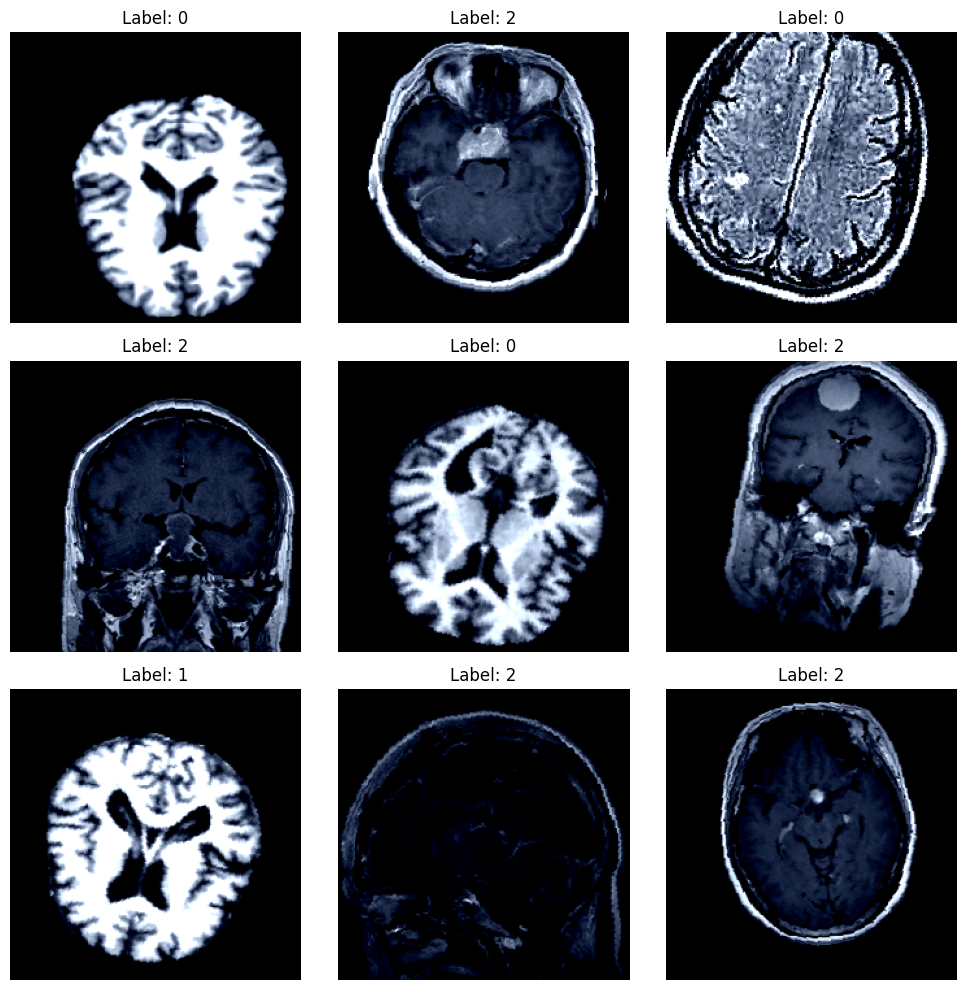

In [14]:
import matplotlib.pyplot as plt
import random

# Pick 9 random indices
indices = random.sample(range(len(train_ds)), 9)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    img, label = train_ds[idx]
    img = img.permute(1, 2, 0)  # convert CHW -> HWC for plotting
    img = img * 0.5 + 0.5       # unnormalize (because we normalized to mean=0.5 std=0.5)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Here we can now train, validate and test different augmentation, models and use different methods to use explainable AI

#### Try Different Augmentation Strategies

You can experiment with different augmentation types:
- `'minimal'`: Basic augmentations (horizontal flip only)
- `'standard'`: Balanced augmentations (default)
- `'aggressive'`: Strong augmentations (more transformations)
- `'autoaugment'`: AutoAugment policy (learned augmentations)

Uncomment and modify the augmentation type below to experiment!


In [ ]:
# Experiment with different augmentation strategies
# Options: 'minimal', 'standard', 'aggressive', 'autoaugment'
AUGMENTATION_TYPE = 'standard'  # Change this to try different strategies

# Recreate train transform with chosen augmentation
train_transform = get_train_transform(IMG_SIZE, augmentation_type=AUGMENTATION_TYPE)
val_test_transform = get_val_transform(IMG_SIZE)

# Recreate datasets with new transforms
train_ds = ApplyTransform(train_subset, transform=train_transform)
val_ds = ApplyTransform(val_subset, transform=val_test_transform)
test_ds = ApplyTransform(test_subset, transform=val_test_transform)

# Recreate data loaders
# Use num_workers=0 on Windows to avoid multiprocessing issues in Jupyter
import platform
import sys
# Force 0 workers on Windows and Colab to prevent crashes/OOM
NUM_WORKERS = 0 if (platform.system() == 'Windows' or 'google.colab' in sys.modules) else 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Using augmentation type: {AUGMENTATION_TYPE}")
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")


Using augmentation type: standard
Train samples: 22819, Val samples: 2684, Test samples: 1343


#### Model Selection

You can try different model architectures:
- `'resnet18'`: Fast, lightweight (default)
- `'resnet34'`: Medium size
- `'resnet50'`: Larger, more capacity
- `'efficientnet_b0'`: Efficient architecture
- `'densenet121'`: Dense connections
- `'mobilenet_v3_small'`: Mobile-optimized


In [16]:
# Choose model architecture
# Options: 'resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3_small'
MODEL_NAME = 'resnet18'  # Change this to try different models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model(num_classes=3, model_name=MODEL_NAME, pretrained=True, dropout=0.5)
print(f"Model: {MODEL_NAME} initialized on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


c:\Users\tahak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tahak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\tahak/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.4MB/s]


Model: resnet18 initialized on cpu
Total parameters: 11,178,051


#### Advanced Training Configuration

Configure training with:
- **Optimizer**: 'adam', 'adamw', 'sgd'
- **Learning Rate Scheduler**: 'reduce_on_plateau', 'cosine', 'onecycle', or None
- **Early Stopping**: Number of epochs to wait before stopping
- **Model Checkpointing**: Automatically saves best model


In [17]:
# Advanced training configuration
TRAINING_CONFIG = {
    'num_epochs': 20,
    'learning_rate': 0.001,
    'optimizer_type': 'adamw',  # Options: 'adam', 'adamw', 'sgd'
    'scheduler_type': 'reduce_on_plateau',  # Options: 'reduce_on_plateau', 'cosine', 'onecycle', None
    'early_stopping_patience': 5,  # Stop if no improvement for N epochs (0 to disable)
    'save_best_model': True,
    'checkpoint_dir': 'checkpoints',
    'weight_decay': 1e-4  # L2 regularization
}

print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

# Train model with advanced features
history = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=TRAINING_CONFIG['num_epochs'],
    device=device,
    learning_rate=TRAINING_CONFIG['learning_rate'],
    optimizer_type=TRAINING_CONFIG['optimizer_type'],
    scheduler_type=TRAINING_CONFIG['scheduler_type'],
    early_stopping_patience=TRAINING_CONFIG['early_stopping_patience'],
    save_best_model=TRAINING_CONFIG['save_best_model'],
    checkpoint_dir=TRAINING_CONFIG['checkpoint_dir'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)


Training Configuration:
  num_epochs: 20
  learning_rate: 0.001
  optimizer_type: adamw
  scheduler_type: reduce_on_plateau
  early_stopping_patience: 5
  save_best_model: True
  checkpoint_dir: checkpoints
  weight_decay: 0.0001
Using device: cpu
Using optimizer: adamw
Using scheduler: reduce_on_plateau

Epoch 1/20
--------------------------------------------------
Learning Rate: 0.001000


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3976 | Train Acc: 0.8057
Val Loss: 0.2816 | Val Acc: 0.8700
✓ Saved best model (Val Acc: 0.8700)

Epoch 2/20
--------------------------------------------------
Learning Rate: 0.001000


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3276 | Train Acc: 0.8444
Val Loss: 0.3749 | Val Acc: 0.8178

Epoch 3/20
--------------------------------------------------
Learning Rate: 0.001000


Training:   0%|          | 0/714 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Load Best Model and Evaluate

After training, you can load the best saved model for evaluation or inference.


In [18]:
# Load the best saved model
if TRAINING_CONFIG['save_best_model']:
    checkpoint_path = Path(TRAINING_CONFIG['checkpoint_dir']) / 'best_model.pth'
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")
        print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")
    else:
        print("No checkpoint found. Using current model state.")


Loaded best model from epoch 1
Best validation accuracy: 0.8700


In [19]:
# Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model(num_classes=3)
print(f"Model initialized on {device}")

Model initialized on cpu


#### Enhanced Training Visualization

Enhanced plots including learning rate schedule and best epoch indicator.


NameError: name 'history' is not defined

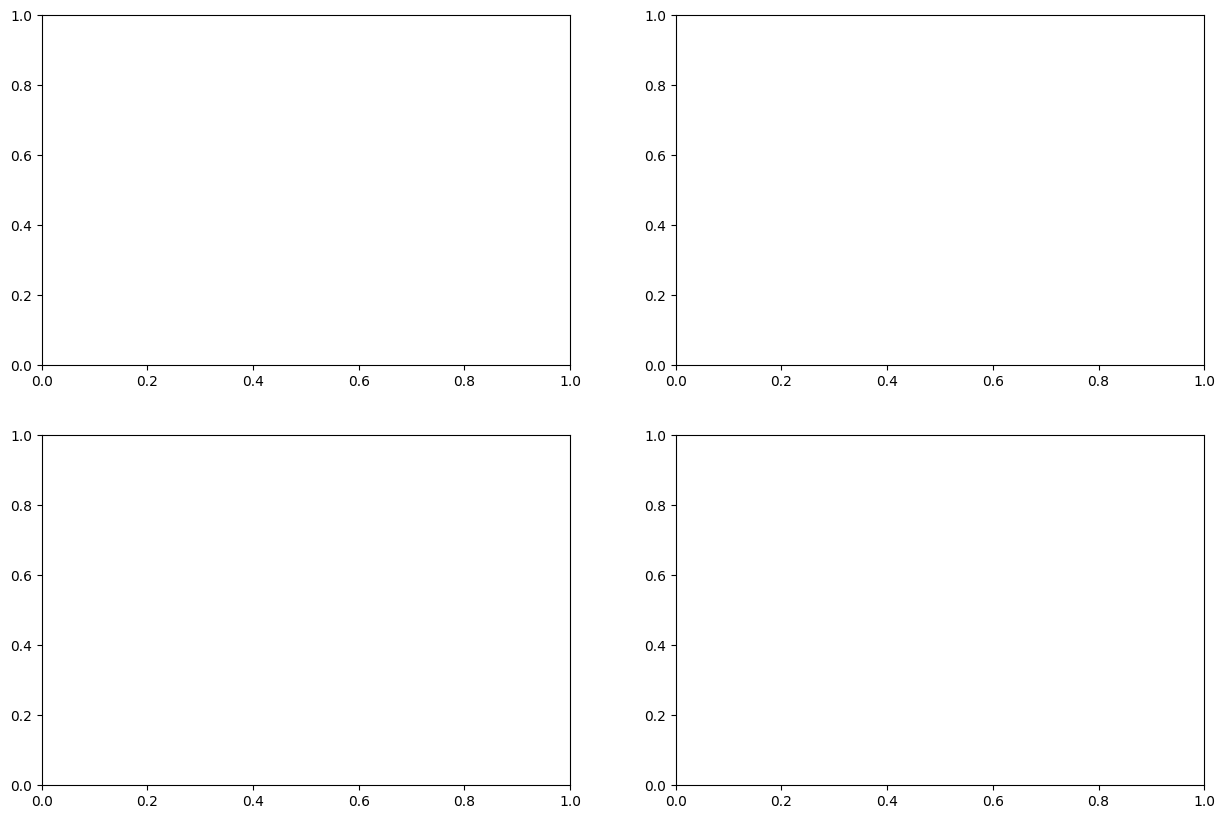

In [ ]:
# Enhanced Plotting with Learning Rate
import matplotlib.pyplot as plt
import numpy as np

# Check if history exists
if 'history' not in globals():
    print("Error: 'history' variable not found. Please run the training cell first.")
    print("The training cell should call train_model() and assign the result to 'history'.")
    print("\nTo train the model, run the cell that contains:")
    print("  history = train_model(...)")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot (if available)
    if 'lr' in history and len(history['lr']) > 0:
        axes[1, 0].plot(history['lr'], marker='o', color='green')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No learning rate data', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Learning Rate Schedule')

    # Best epoch indicator
    best_epoch = np.argmax(history['val_acc'])
    axes[1, 1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch+1}')
    axes[1, 1].plot(history['val_acc'], label='Val Acc', marker='o')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].set_title(f'Best Validation Accuracy: {max(history["val_acc"]):.4f} at Epoch {best_epoch+1}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nTraining Summary:")
    print(f"  Best Validation Accuracy: {max(history['val_acc']):.4f} at Epoch {best_epoch+1}")
    print(f"  Final Training Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"  Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final Validation Loss: {history['val_loss'][-1]:.4f}")


#### Evaluate on Test Set

Evaluate the trained model on the test set with detailed metrics and confusion matrix.


In [ ]:
# Evaluate on test set
from eval import evaluate_model, plot_confusion_matrix
from sklearn.metrics import classification_report

# Get class names from the dataset
class_names = ['Healthy', 'Alzheimer', 'Tumor']

# Evaluate model
results = evaluate_model(model, test_loader, device, class_names=class_names)

print(f"\nTest Set Accuracy: {results['accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(
    results['true_labels'], 
    results['predictions'], 
    target_names=class_names
))

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'], class_names)
plt.show()


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Train Model
history = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device
)

Using device: cpu
Using optimizer: adam
Using scheduler: reduce_on_plateau

Epoch 1/10
--------------------------------------------------
Learning Rate: 0.001000


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3718 | Train Acc: 0.8208
Val Loss: 0.3750 | Val Acc: 0.8301
✓ Saved best model (Val Acc: 0.8301)

Epoch 2/10
--------------------------------------------------
Learning Rate: 0.001000


Training:   0%|          | 0/714 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Plot Results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()

Error: 'history' variable not found. Please run the training cell first.
The training cell should call train_model() and assign the result to 'history'.

To train the model, run the cell that contains:
  history = train_model(...)
